# OpenCVによるカメラキャリブレーション（部分チェスボード対応）
このノートブックでは、OpenCVを使ってカメラの内部パラメータ（行列K、歪み係数など）を
複数枚のチェスボード画像（交点が全て見えない可能性あり）から推定します。
また、最も特徴点の多い画像に対して誤差を可視化します。

In [1]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

## チェスボードの設定と世界座標系の定義

In [2]:
# チェッカーボードの設定（交点数）
CHECKERBOARD = (23, 15)
objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

# データ格納用
objpoints = []  # 実世界の点
imgpoints = []  # 画像上の点
corner_counts = []  # コーナー数を記録

# 最低必要な検出点数（全体の50%）
min_required_corners = int(0.5 * CHECKERBOARD[0] * CHECKERBOARD[1])

## キャリブレーション画像の読み込みとコーナー検出

In [3]:
# キャリブレーション用画像のパスを指定
image_dir = "./carib_test/int_carib_images"  # 適宜変更
images = glob.glob(os.path.join(image_dir, '*.JPG'))
# 見つからない場合はエラーメッセージを表示
if not images:
    print("指定されたディレクトリに画像が見つかりません。パスを確認してください。")
    exit(1)

for fname in images:
    img = cv2.imread(fname)
    if img is None:
        print(f"画像 {fname} を読み込めません。スキップします。")
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    flags = cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, flags)

    if ret and len(corners) >= min_required_corners:
        corners2 = cv2.cornerSubPix(
            gray, corners, (11, 11), (-1, -1),
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        )
        objpoints.append(objp)
        imgpoints.append(corners2)
        corner_counts.append((len(corners2), fname))
        print(f"{fname}: コーナー数 = {len(corners2)}")
    else:
        print(f"{fname}: コーナー検出失敗または点数不足（{len(corners) if ret else 0} 点）")

./carib_test/int_carib_images/IMG_3496.JPG: コーナー検出失敗または点数不足（0 点）
./carib_test/int_carib_images/IMG_3495.JPG: コーナー検出失敗または点数不足（0 点）
./carib_test/int_carib_images/IMG_3494.JPG: コーナー検出失敗または点数不足（0 点）
./carib_test/int_carib_images/IMG_3490.JPG: コーナー数 = 345
./carib_test/int_carib_images/IMG_3491.JPG: コーナー検出失敗または点数不足（0 点）
./carib_test/int_carib_images/IMG_3485.JPG: コーナー数 = 345
./carib_test/int_carib_images/IMG_3493.JPG: コーナー検出失敗または点数不足（0 点）
./carib_test/int_carib_images/IMG_3487.JPG: コーナー数 = 345
./carib_test/int_carib_images/IMG_3486.JPG: コーナー検出失敗または点数不足（0 点）
./carib_test/int_carib_images/IMG_3492.JPG: コーナー検出失敗または点数不足（0 点）
./carib_test/int_carib_images/IMG_3488.JPG: コーナー検出失敗または点数不足（0 点）
./carib_test/int_carib_images/IMG_3489.JPG: コーナー検出失敗または点数不足（0 点）


## キャリブレーションの実行と誤差評価

In [ ]:
if len(objpoints) >= 3:
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    print("内部行列:\n", K)
    print("歪み係数:\n", dist.ravel())

    total_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], K, dist)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
        total_error += error
    print("平均リプロジェクション誤差:", total_error / len(objpoints))
else:
    print("有効な画像が不足しています。最低3枚必要です。")

# K, dist, rvecs, tvecsを保存
np.savez("camera_calibration_result.npz", K=K, dist=dist, rvecs=rvecs, tvecs=tvecs)

内部行列:
 [[2.97077109e+03 0.00000000e+00 2.06969862e+03]
 [0.00000000e+00 2.99833557e+03 1.61256551e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
歪み係数:
 [ 0.088716   -0.19549145  0.00234354  0.00126466  0.17708618]
平均リプロジェクション誤差: 0.08048265465321806


## 最も多くキーポイントが見つかった画像で可視化

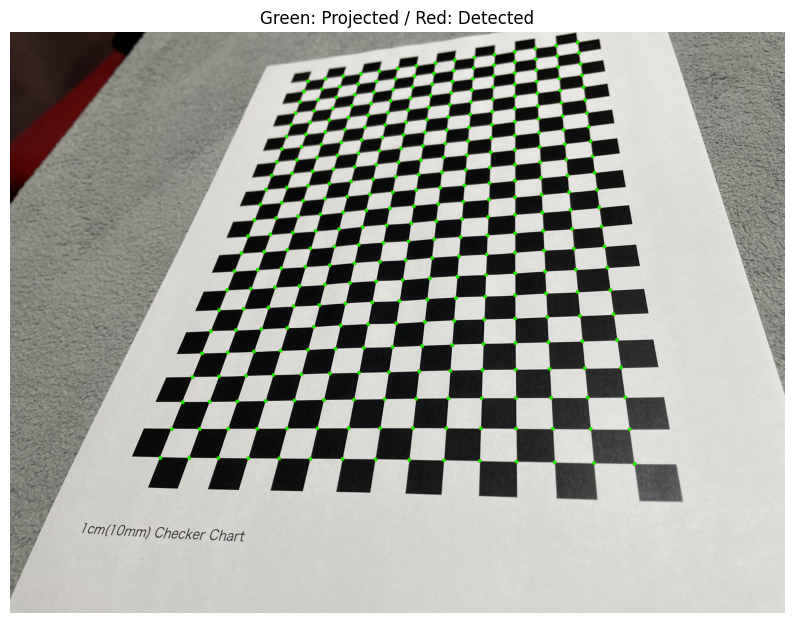

In [6]:
if corner_counts:
    max_count, max_file = max(corner_counts, key=lambda x: x[0])
    idx = [i for i, (_, f) in enumerate(corner_counts) if f == max_file][0]
    img = cv2.imread(max_file)
    img_draw = img.copy()

    imgpoints2, _ = cv2.projectPoints(objpoints[idx], rvecs[idx], tvecs[idx], K, dist)
    for pt in imgpoints2:
        x, y = int(pt[0][0]), int(pt[0][1])
        cv2.circle(img_draw, (x, y), 10, (0, 255, 0), -1)
    for pt in imgpoints[idx]:
        x, y = int(pt[0][0]), int(pt[0][1])
        cv2.circle(img_draw, (x, y), 10, (0, 0, 255), 1)

    plt.figure(figsize=(10, 8))
    plt.title("Green: Projected / Red: Detected")
    plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()